<a href="https://colab.research.google.com/github/chi-hun/kaggle/blob/main/COVID_19_AI_Detection_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COVID-19 AI Detection Challenge https://www.kaggle.com/competitions/covid-19-ai-detection-challenge/overview

# import

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!apt update && apt install -y openslide-tools
!pip install openslide-python

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://security.ubuntu.com/ubuntu 

In [1]:
from google.colab import files
import os
from tqdm import tqdm
from glob import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from openslide import OpenSlide
import tensorflow as tf
from tensorflow.keras import layers

# data load

In [5]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod -600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
!kaggle competitions download -c covid-19-ai-detection-challenge

 99% 329M/332M [00:18<00:00, 20.1MB/s]
100% 332M/332M [00:18<00:00, 18.7MB/s]


In [7]:
!unzip /content/covid-19-ai-detection-challenge.zip

Archive:  /content/covid-19-ai-detection-challenge.zip
  inflating: Test set/Test set/1000.JPG  
  inflating: Test set/Test set/1001.JPG  
  inflating: Test set/Test set/1002.JPG  
  inflating: Test set/Test set/1003.JPG  
  inflating: Test set/Test set/1004.JPG  
  inflating: Test set/Test set/1005.JPG  
  inflating: Test set/Test set/1006.JPG  
  inflating: Test set/Test set/1007.JPG  
  inflating: Test set/Test set/1008.JPG  
  inflating: Test set/Test set/1009.JPG  
  inflating: Test set/Test set/1010.JPG  
  inflating: Test set/Test set/1011.JPG  
  inflating: Test set/Test set/1012.JPG  
  inflating: Test set/Test set/1013.JPG  
  inflating: Test set/Test set/1014.JPG  
  inflating: Test set/Test set/1015.JPG  
  inflating: Test set/Test set/1016.JPG  
  inflating: Test set/Test set/1017.JPG  
  inflating: Test set/Test set/1018.JPG  
  inflating: Test set/Test set/1019.JPG  
  inflating: Test set/Test set/1020.JPG  
  inflating: Test set/Test set/1021.JPG  
  inflating: Test set

In [8]:
train_csv = pd.read_csv('/content/trainlabel.csv')

# EDA

## info

In [ ]:
train_csv.head()

,Id,Class
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      1669 non-null   int64
 1   Class   1669 non-null   int64
dtypes: int64(2)
memory usage: 26.2 KB


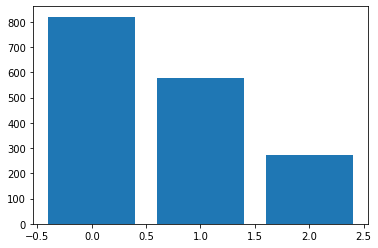

In [ ]:
cl = train_csv['Class'].value_counts()
plt.bar(cl.index, cl)
plt.show()

## info(img)

In [ ]:
img_pa_tr = glob('/content/Training set/Training set/*')
for i in img_pa_tr:
    a = PIL.Image.open(i)
    img_size = a.size   
    train_csv.loc[train_csv['Id'] == int(i.split('/')[-1].split('.')[0]),'width'] = img_size[0]
    train_csv.loc[train_csv['Id'] == int(i.split('/')[-1].split('.')[0]),'height'] = img_size[1]

In [ ]:
train_csv

,Id,Class,width,height
0,1,0,494.0,372.0
1,2,0,385.0,275.0
2,3,0,435.0,335.0
3,4,0,351.0,248.0
4,5,0,466.0,262.0
...,...,...,...,...
1664,1871,2,578.0,430.0
1665,1872,2,603.0,443.0
1666,1873,2,581.0,445.0
1667,1874,2,607.0,440.0


In [ ]:
print(train_csv['width'].max())
print(train_csv['width'].min())
print(train_csv['height'].max())
print(train_csv['height'].min())
print(train_csv['width'].mean())
print(train_csv['height'].mean())

719.0
246.0
553.0
136.0
500.63253012048193
360.94879518072287


## image div

In [9]:
os.mkdir('/content/Training set/0')
os.mkdir('/content/Training set/1')
os.mkdir('/content/Training set/2')

In [10]:
img_pa_tr = glob('/content/Training set/Training set/*')

In [11]:
for i in tqdm(img_pa_tr):
    wh = train_csv[train_csv['Id'] == int(i.split('/')[-1].split('.')[0])]['Class'].values[0]
    file_destination = f'/content/Training set/{wh}'
    shutil.move(i, file_destination)

100%|██████████| 1660/1660 [00:00<00:00, 2150.93it/s]


In [12]:
shutil.rmtree('/content/Training set/Training set/')

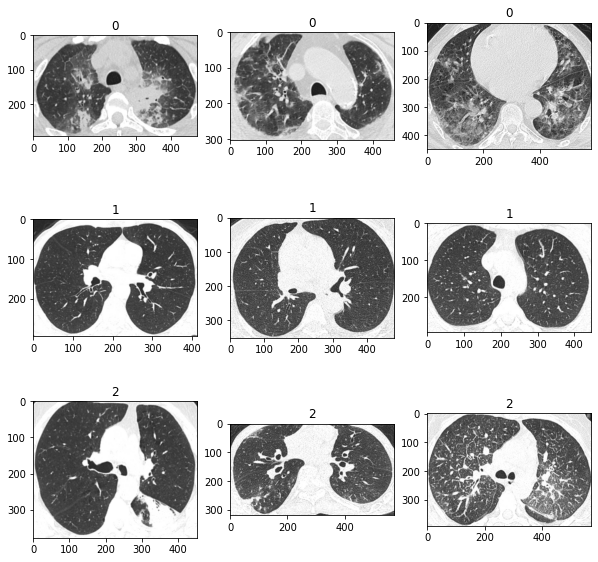

In [13]:
img_0 = glob('/content/Training set/0/*')
img_1 = glob('/content/Training set/1/*')
img_2 = glob('/content/Training set/2/*')
plt.figure(figsize=(10,10)) 
for i in range(3):
    plt.subplot(3,3,i+1)
    plt.title('0')
    img = PIL.Image.open(img_0[i])
    plt.imshow(img)
for i in range(3):
    plt.subplot(3,3,i+4)
    plt.title('1')
    img = PIL.Image.open(img_1[i])
    plt.imshow(img)
for i in range(3):
    plt.subplot(3,3,i+7)
    plt.title('2')
    img = PIL.Image.open(img_2[i])
    plt.imshow(img)
plt.show()

# data_set

In [14]:
img_size = (350,350)
train_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/Training set',
                                                               image_size = img_size,
                                                               validation_split=0.2,
                                                               subset='training',
                                                               seed=42)

Found 1660 files belonging to 3 classes.
Using 1328 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/Training set',
                                                               image_size = img_size,
                                                               validation_split=0.2,
                                                               subset='validation',
                                                               seed=42)

Found 1660 files belonging to 3 classes.
Using 332 files for validation.


In [16]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/Test set',
                                                               image_size = img_size,
                                                               shuffle = False)
                                                               

Found 441 files belonging to 1 classes.


In [17]:
class_names = train_ds.class_names
class_names

['0', '1', '2']

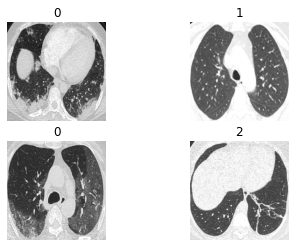

In [ ]:
for i, j in train_ds.take(1):
    for k in range(4):
        plt.subplot(2,2,k+1)
        plt.title(class_names[j[k]])
        plt.imshow(i[k].numpy().astype('uint8'))
        plt.axis(False)
plt.show()

# modeling

## make cv

In [28]:
def model_make1():
    inputs = layers.Input(shape=(img_size[0],img_size[1],3))
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = layers.experimental.preprocessing.RandomFlip('horizontal')(x)
    x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
    x = layers.experimental.preprocessing.RandomZoom(0.1)(x)

    x = layers.Conv2D(128, 3, padding='same', activation = 'relu')(x)
    x = layers.Conv2D(128, 3, activation = 'relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation = 'relu')(x)
    x = layers.Conv2D(64, 3, activation = 'relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(32, 3, padding='same', activation = 'relu')(x)
    x = layers.Conv2D(32, 3, activation = 'relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.1)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [29]:
model = model_make1()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 350, 350, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 350, 350, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 350, 350, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 350, 350, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 350, 350, 128)     3584      
                                                           

In [20]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
42/42 [==============================] - 89s 1s/step - loss: 1.7005 - accuracy: 0.3276 - val_loss: 1.5690 - val_accuracy: 0.0030
Epoch 2/10
42/42 [==============================] - 53s 1s/step - loss: 1.4993 - accuracy: 0.3908 - val_loss: 1.5590 - val_accuracy: 0.2139
Epoch 3/10
42/42 [==============================] - 53s 1s/step - loss: 1.3269 - accuracy: 0.4548 - val_loss: 1.2792 - val_accuracy: 0.3735
Epoch 4/10
42/42 [==============================] - 53s 1s/step - loss: 1.2361 - accuracy: 0.4812 - val_loss: 1.5733 - val_accuracy: 0.2982
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 1.1521 - accuracy: 0.5316 - val_loss: 1.6970 - val_accuracy: 0.3464
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 1.0826 - accuracy: 0.5550 - val_loss: 1.6339 - val_accuracy: 0.3614
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 1.0939 - accuracy: 0.5595 - val_loss: 1.1612 - val_accuracy: 0.5030
Epoch 8/10
42/42 [==

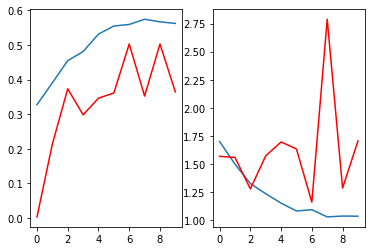

In [22]:
plt.subplot(1,2,1)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'], '-r')
plt.subplot(1,2,2)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'], '-r')

In [23]:
pre = model.predict(test_ds)

In [24]:
pre

array([[0.1754058 , 0.7433173 , 0.07255539, 0.0087215 ],
       [0.19586948, 0.71996146, 0.07561198, 0.00855704],
       [0.18094014, 0.73705643, 0.07334246, 0.00866098],
       ...,
       [0.09990994, 0.8270236 , 0.06336552, 0.00970089],
       [0.11471214, 0.8114487 , 0.06453986, 0.00929931],
       [0.13936871, 0.78418887, 0.06742394, 0.00901849]], dtype=float32)

In [25]:
pree = np.argmax(pre, axis=1)
pref = []
for i in pree:
    pref.append(class_names[i])

In [27]:
class_names

['0', '1', '2']

In [ ]:
pref

In [ ]:
file_paths = test_ds.file_paths
file_paths

In [32]:
sub = pd.read_csv('/content/sample_submission.csv')
sub

,Id,Class
0,275,NaN
1,276,NaN
2,277,NaN
3,278,NaN
4,279,NaN
...,...,...
433,1019,NaN
434,1020,NaN
435,1021,NaN
436,1022,NaN


In [37]:
for i in range(len(pref)):
    test_name = int(file_paths[i].split('/')[-1].split('.')[0])
    sub.loc[sub['Id'] == test_name, 'Class'] = pref[i]


In [38]:
sub.head()

,Id,Class
0,275,1
1,276,1
2,277,1
3,278,1
4,279,1


In [39]:
sub.to_csv('submission.csv', index=False)

## mobilenet_v3

### mobilenet_v3(full)

In [ ]:
pre_lalyer = tf.keras.applications.mobilenet_v3
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(img_size[0],img_size[1],3),
                                                    include_top=False,
                                                    wdight='imagenet')